# Análise dos testes

### Imports

In [1]:
from os import makedirs
from os.path import join
from json import load, dump

from scripts.test import Test
from scripts.data import LesionData, DatasetAnalysis

import scripts.definitions as defs
import scripts.analysis as analysis

### Configuração

In [2]:
TEST_NAME = 'LLaDerm-0.1-11B-4bit-SC_test_2025-04-08T07_21_49.243036.json'

### Carregamento dos testes e dados

In [3]:
with open(join(defs.RESULTS_PATH, 'tests', TEST_NAME), 'r', encoding='utf-8') as file:
    test = Test(**load(file))

with open(join(defs.DATA_PATH, 'stt_data', 'test_dataset.json'), 'r', encoding='utf-8') as file:
    test_dataset = [LesionData(**data) for data in load(file)]

with open(join(defs.DATA_PATH, 'stt_data', 'training_dataset.json'), 'r', encoding='utf-8') as file:
    training_dataset = [LesionData(**data) for data in load(file)]

with open(join(defs.DATA_PATH, 'test_dataset_analysis.json'), 'r', encoding='utf-8') as file:
    test_dataset_analysis = DatasetAnalysis(**load(file))

with open(join(defs.DATA_PATH, 'training_dataset_analysis.json'), 'r', encoding='utf-8') as file:
    training_dataset_analysis = DatasetAnalysis(**load(file))

### Processamento dos testes

In [4]:
sanitized_results_on_test = analysis.structure_answers(test.model.prompt_type, test.results_on_test_data)
sanitized_results_on_training = analysis.structure_answers(test.model.prompt_type, test.results_on_training_data)

### Salvamento dos testes processados

In [5]:
valid_results_on_test = list(filter(lambda x: x.answer.valid, sanitized_results_on_test))
invalid_results_on_test = list(filter(lambda x: not x.answer.valid, sanitized_results_on_test))

print(
    f'Resultados válidos para testes sobre dados de teste: {len(sanitized_results_on_test) - len(invalid_results_on_test)}')
print(f'Resultados inválidos para testes sobre dados de teste: {len(invalid_results_on_test)}')

valid_results_on_training = list(filter(lambda x: x.answer.valid, sanitized_results_on_training))
invalid_results_on_training = list(filter(lambda x: not x.answer.valid, sanitized_results_on_training))

print(
    f'Resultados válidos para testes sobre dados de treinamento: {len(sanitized_results_on_test) - len(invalid_results_on_training)}')
print(f'Resultados inválidos para testes sobre dados de treinamento: {len(invalid_results_on_training)}')

test_analysis = analysis.TestAnalysis(
    test_name=TEST_NAME,
    valid_results_on_test_data=valid_results_on_test,
    valid_results_on_training_data=valid_results_on_training,
    invalid_results_on_test_data=invalid_results_on_test,
    invalid_results_on_training_data=invalid_results_on_training
)

makedirs(join(defs.RESULTS_PATH, 'tests', 'analysis'), exist_ok=True)

with open(join(defs.RESULTS_PATH, 'tests', 'analysis', TEST_NAME.replace('.json', '_analysis.json')), 'w', encoding='utf-8') as file:
    dump(test_analysis.model_dump(), file, indent=4, ensure_ascii=False)

Resultados válidos para testes sobre dados de teste: 595
Resultados inválidos para testes sobre dados de teste: 0
Resultados válidos para testes sobre dados de treinamento: 595
Resultados inválidos para testes sobre dados de treinamento: 0


### Associação de pares com as respostas corretas

In [6]:
result_pairs_on_test = analysis.associate_results_with_data(test_dataset,
                                                            test.model.prompt_type,
                                                            sanitized_results_on_test)

result_pairs_on_training = analysis.associate_results_with_data(test_dataset,
                                                                test.model.prompt_type,
                                                                sanitized_results_on_training)

### Análise

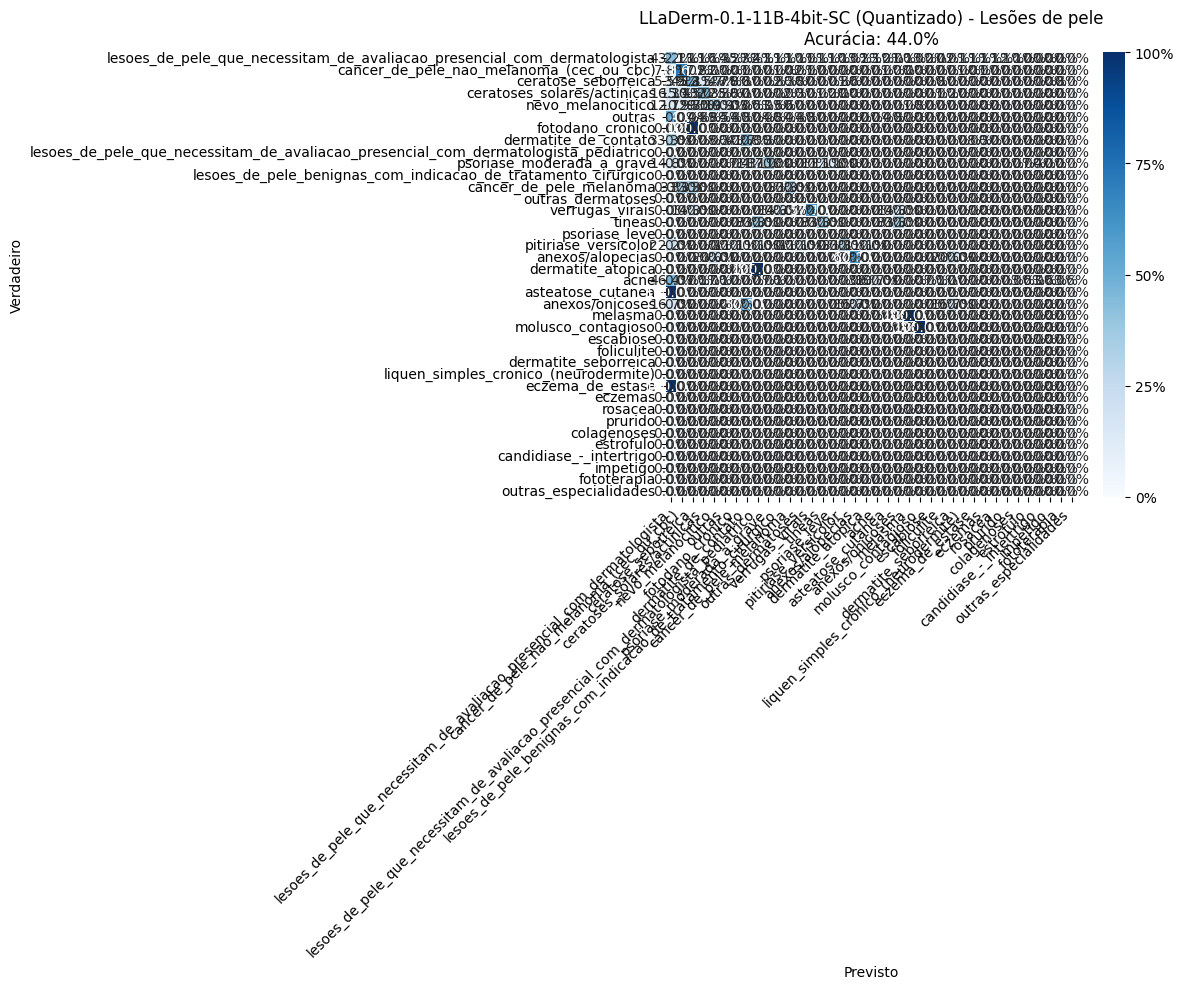

In [7]:
model_name = test.tested_model
quantized = '(Quantizado)' if test.model.quantized else ''

skin_lesion_pairs = analysis.get_label_pairs(result_pairs_on_test, 'skin_lesion')

skin_lesion_labels = [analysis.sanitize_domain_class(key) for key in training_dataset_analysis.skin_lesion_distribution.classes]

# TODO: Melhorar a visualização da matriz de confusão
skin_lesion_accuracy = analysis.create_confusion_matrix(skin_lesion_pairs,  # type: ignore
                                                        skin_lesion_labels,
                                                        f'{model_name} {quantized} - Lesões de pele',
                                                        join(defs.RESULTS_PATH, 'plots', f'skin_lesions_{TEST_NAME[:-4]}'))

if test.model.prompt_type == defs.PromptType.REPORT:
    elementary_lesion_pairs = analysis.get_label_pairs(result_pairs_on_test, 'elementary_lesions')
    secondary_lesion_pairs = analysis.get_label_pairs(result_pairs_on_test, 'secondary_lesions')
    coloration_pairs = analysis.get_label_pairs(result_pairs_on_test, 'coloration')
    morphology_pairs = analysis.get_label_pairs(result_pairs_on_test, 'morphology')
    size_pairs = analysis.get_label_pairs(result_pairs_on_test, 'size')
    risk_pairs = analysis.get_label_pairs(result_pairs_on_test, 'risk')

    elementary_lesion_labels = [key[0] for key in training_dataset_analysis.elementary_lesions_distribution.classes]
    secondary_lesion_labels = [key[0] for key in training_dataset_analysis.secondary_lesions_distribution.classes]
    coloration_labels = [key[0] for key in training_dataset_analysis.coloration_distribution.classes]
    morphology_labels = [key[0] for key in training_dataset_analysis.morphology_distribution.classes]
    size_labels = [key[0] for key in training_dataset_analysis.size_distribution.classes]
    risk_labels = [key[0] for key in training_dataset_analysis.risk_distribution.classes]

    elementary_lesion_accuracy = analysis.create_multilabel_confusion_matrix(elementary_lesion_pairs,  # type: ignore
                                                                             elementary_lesion_labels,
                                                                             f'{model_name} {quantized} - Lesões elementares',
                                                                             join(defs.RESULTS_PATH, 'plots', f'elementary_lesions_{TEST_NAME[:-4]}'))

    secondary_lesion_accuracy = analysis.create_multilabel_confusion_matrix(secondary_lesion_pairs,  # type: ignore
                                                                            secondary_lesion_labels,
                                                                            f'{model_name} {quantized} - Lesões secundárias',
                                                                            join(defs.RESULTS_PATH, 'plots', f'secondary_lesions_{TEST_NAME[:-4]}'))

    coloration_accuracy = analysis.create_multilabel_confusion_matrix(coloration_pairs,  # type: ignore
                                                                      coloration_labels,
                                                                      f'{model_name} {quantized} - Coloração',
                                                                      join(defs.RESULTS_PATH, 'plots', f'coloration_{TEST_NAME[:-4]}'))

    morphology_accuracy = analysis.create_multilabel_confusion_matrix(morphology_pairs,  # type: ignore
                                                                      morphology_labels,
                                                                      f'{model_name} {quantized} - Morfologia',
                                                                      join(defs.RESULTS_PATH, 'plots', f'morphology_{TEST_NAME[:-4]}'))

    size_accuracy = analysis.create_confusion_matrix(size_pairs,  # type: ignore
                                                     size_labels,
                                                     f'{model_name} {quantized} - Tamanho',
                                                     join(defs.RESULTS_PATH, 'plots', f'size_{TEST_NAME[:-4]}'))

    risk_accuracy = analysis.create_confusion_matrix(risk_pairs,  # type: ignore
                                                     risk_labels,
                                                     f'{model_name} {quantized} - Classificação de risco',
                                                     join(defs.RESULTS_PATH, 'plots', f'risk_{TEST_NAME[:-4]}'))